<a href="https://colab.research.google.com/github/marcellmello/Tembici-Analysis/blob/main/MSc_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <center> IoT Device on Bicycle Safety: a case study with an unsupervised clustering model to estimate hazardous areas </center>

<center> MSc Analysis </center>
<center> Universidade de Brasília (PPGT/UnB) </center>

<center>MSc Candidate: <a href="https://www.linkedin.com/in/marcelmello/" target="_blank"> LinkedIn </a></center>
<center> Curriculum: <a href="" target="_blank"> Lattes </a></center>

This research aimed to estimate hazardous areas for bicycle mobility by comparing unsupervised machine-learning algorithms based on an Internet of Things sensor device for data collection. The Lateral Passing Distance (LPD) data collected among bicycles and vehicles were related to a variate cyclist data. Some of this data includes bicycle velocity, curse elevation, global positioning system (GPS) coordinates, acceleration, and gyroscopic information through a naturalistic collection on the street. 

In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

#Python Libraries

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
!pip install geopandas --quiet
!pip install contextily --quiet

import matplotlib.pyplot as plt
import matplotlib.colors as colors
import plotly.express as px

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score as ss
from scipy import stats
import scipy.stats as stats


import geopandas as gpd
import contextily #mapas estaticos
import folium #mapas dinâmicos(html)
from shapely.geometry import Point

print('Python dependencies installed')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 49.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 116.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 98.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.1/20.1 MB 18.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.4/55.4 KB 7.1 MB/s eta 0:00:00
Python dependencies installed


In [4]:
df = pd.read_excel("/content/drive/MyDrive/MSc/park_analysis4_total.xlsx")

  #csv dando problema de encode

# Exploratory Data Analysis

In [5]:
df.head(3)

,latitude,longitude,accex,accey,accez,climb,gyrox,gyroy,gyroz,us_lpd_left,speed
0,-15.804338,-47.910262,2.810793,0.689530,2.487576,0.195,49.954198,0.290076,-14.366412,189.04,9.062
1,-15.797828,-47.911870,-0.062249,6.449979,19.612701,0.190,55.763359,7.351145,-10.389313,160.03,6.722
2,-15.808282,-47.926879,0.423774,8.176199,-5.906495,0.147,-8.717557,-1.816794,-10.396947,65.30,3.850


In [6]:
exp = df.copy()
exp.rename(columns = {' us_lpd_left':'lpd'}, inplace = True)

Lateral Passing Distance Statistics

In [7]:
exp['lpd'].describe()

count    161.000000
mean     259.523665
std      155.390313
min        2.580000
25%      136.360000
50%      235.970000
75%      350.220000
max      693.170000
Name: lpd, dtype: float64

Lateral Passing Distance Histogram with Kernel Density Estimation (KDE)

<ipython-input-8-7d349b1fa37e>:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  expkde = sns.distplot(exp['lpd'], bins=15)


Text(0.5, 0, 'Lateral Passing Distance (cm)')

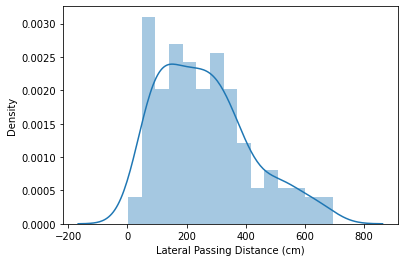

In [8]:
expkde = sns.distplot(exp['lpd'], bins=15)
expkde.set_xlabel("Lateral Passing Distance (cm)")

<ipython-input-9-7b70715efd2c>:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  expkde2 = sns.distplot(exp['speed'], bins=15)


Text(0.5, 0, 'Speed (m/s)')

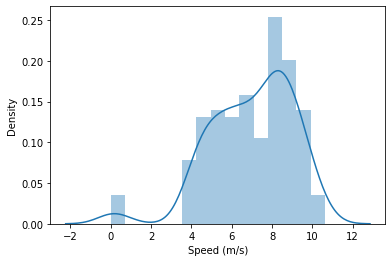

In [9]:
expkde2 = sns.distplot(exp['speed'], bins=15)
expkde2.set_xlabel("Speed (m/s)")

Relationship between Climb and LPD

In [10]:
exp_climb_lpd = px.scatter(exp, x='lpd',y='climb', color='lpd')
exp_climb_lpd

Percentage of values in ascending and downward movement regarding the threshold lateral clearance distance of 150cm. 
(LPD < 150cm uphill)

In [11]:
up = exp[(exp['climb'] > 0) & (exp['lpd'] < 150)].value_counts('lpd')
down = exp[(exp['climb'] < 0) & (exp['lpd'] < 150)].value_counts('lpd')

p = up.count()/down.count()
(p-1)*100

4.347826086956519

When relating LPD to Climb and Speed, the following correlation was obtained by fitting a regression model to observe the resulting line on a 95% confidence interval. The LPD is on the y-axis, and the climb and speed data are on the x-axis.

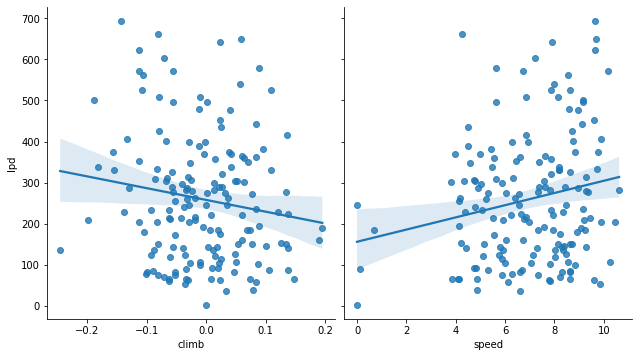

In [12]:
sns.pairplot(exp, x_vars=["climb", "speed"], y_vars=["lpd"], height=5, aspect=.9, kind="reg");

Acceleration and Rotation correlation to LPD, fitting a regression model to observe the resulting line on a 95% confidence interval.

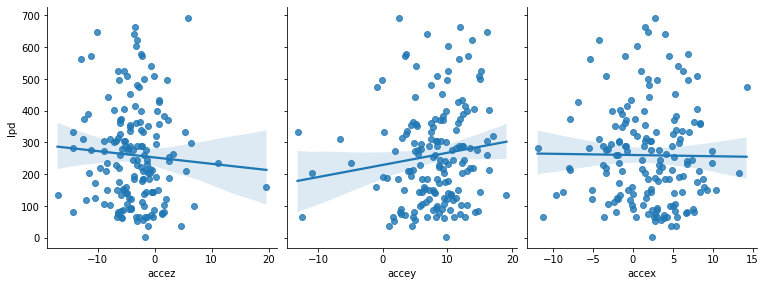

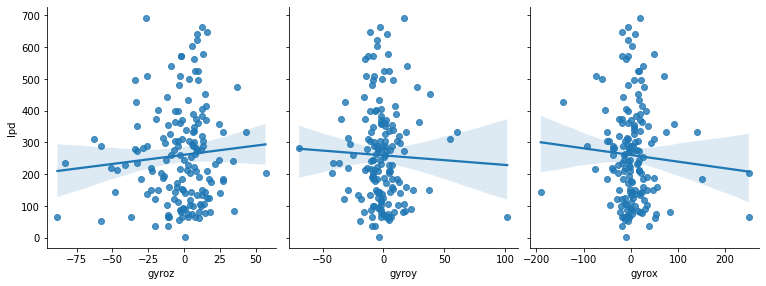

In [13]:
sns.pairplot(exp, x_vars=["accez",'accey',"accex"], y_vars=["lpd"], height=4, aspect=.9, kind="reg");
sns.pairplot(exp, x_vars=["gyroz",'gyroy',"gyrox"], y_vars=["lpd"], height=4, aspect=.9, kind="reg");

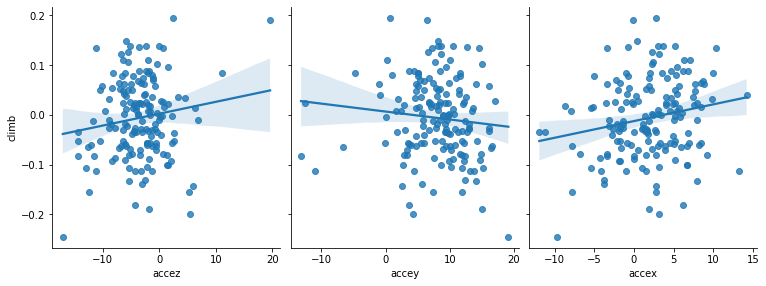

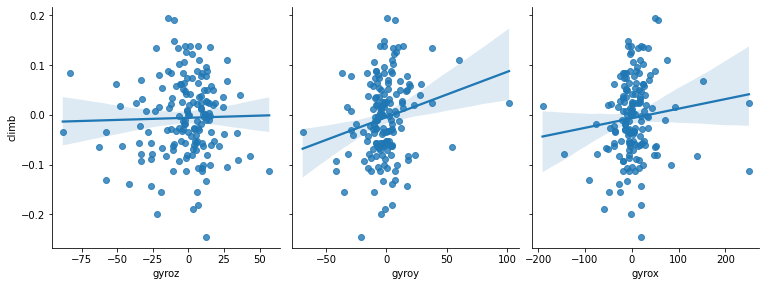

In [14]:
sns.pairplot(exp, x_vars=["accez",'accey',"accex"], y_vars=["climb"], height=4, aspect=.9, kind="reg");
sns.pairplot(exp, x_vars=["gyroz",'gyroy',"gyrox"], y_vars=["climb"], height=4, aspect=.9, kind="reg");


#Accident history - Geo Pandas

In [15]:
import pandas as pd
geo = pd.read_excel('/content/drive/MyDrive/MSc/sinistrosbike_pdc.xlsx')

In [16]:
geo.head(3)

,fid,Fatalidade,Data,Dia,Jurisdicao,RA,Via-Av.,Endereco,Natureza,Vit. Falta,Vit. Ferido,Veiculo,Ano,latitude,longitude
0,3632,NÃO,2019-07-17,4-QUA,VIA URBANA,BRASÍLIA,VIA DO PARQUE DA CIDADE,"VIA DO PARQUE DA CIDADE, PRÓX. AO ESTACIONAMEN...",COLISÃO,-,1,CAMINHONETA x BICICLETA,2019,-15.792456,-47.896588
1,3990,NÃO,2019-07-16,3-TER,VIA URBANA,BRASÍLIA,VIA DO PARQUE DA CIDADE,"VIA DO PARQUE DA CIDADE, SRPS, PRÓX. AO PAVILH...",COLISÃO,-,1,BICICLETA x AUTOMÓVEL,2019,-15.795415,-47.910087
2,5129,NÃO,2017-10-03,3-TER,VIA URBANA,BRASÍLIA,VIA DO PARQUE DA CIDADE,"VIA DO PARQUE DA CIDADE, PRÓX. AO ESTACIONAMEN...",COLISÃO,-,1,CAMINHONETA x BICICLETA,2017,-15.803819,-47.905642


In [17]:
import geopandas as gpd
geometry = [Point(xy) for xy in zip(geo['longitude'], geo['latitude'])]
geo_pdc = gpd.GeoDataFrame(geo, crs='EPSG:4326', geometry=geometry)

  #crio uma coluna com pontos de longitude e latidude agrupados.
  #tranformo o df em GeoDataFrame
  #ajusto o sistema de coordenadas geo - EPSG:4326

#geo_pdc = geo_pdc.to_crs(crs='EPSG:3857')
#geo_pdc.crs.to_string()

  #altero o sis de coordenadas geo para EPSG:3857 (trabalha em metros)
  #confere crs

In [18]:
geo_pdc.head()

,fid,Fatalidade,Data,Dia,Jurisdicao,RA,Via-Av.,Endereco,Natureza,Vit. Falta,Vit. Ferido,Veiculo,Ano,latitude,longitude,geometry
0,3632,NÃO,2019-07-17,4-QUA,VIA URBANA,BRASÍLIA,VIA DO PARQUE DA CIDADE,"VIA DO PARQUE DA CIDADE, PRÓX. AO ESTACIONAMEN...",COLISÃO,-,1,CAMINHONETA x BICICLETA,2019,-15.792456,-47.896588,POINT (-47.89659 -15.79246)
1,3990,NÃO,2019-07-16,3-TER,VIA URBANA,BRASÍLIA,VIA DO PARQUE DA CIDADE,"VIA DO PARQUE DA CIDADE, SRPS, PRÓX. AO PAVILH...",COLISÃO,-,1,BICICLETA x AUTOMÓVEL,2019,-15.795415,-47.910087,POINT (-47.91009 -15.79542)
2,5129,NÃO,2017-10-03,3-TER,VIA URBANA,BRASÍLIA,VIA DO PARQUE DA CIDADE,"VIA DO PARQUE DA CIDADE, PRÓX. AO ESTACIONAMEN...",COLISÃO,-,1,CAMINHONETA x BICICLETA,2017,-15.803819,-47.905642,POINT (-47.90564 -15.80382)
3,5189,NÃO,2018-08-07,3-TER,VIA URBANA,BRASÍLIA,VIA DO PARQUE DA CIDADE,"VIA DO PARQUE DA CIDADE, PRÓX. AO GIBÃO",COLISÃO,-,1,BICICLETA x CAMINHONETA,2018,-15.804182,-47.920026,POINT (-47.92003 -15.80418)
4,5451,NÃO,2018-12-16,1-DOM,VIA URBANA,BRASÍLIA,VIA DO PARQUE DA CIDADE,"VIA DO PARQUE DA CIDADE, PRÓX. AO ALPINOS",COLISÃO,-,1,CAMINHONETA x BICICLETA,2018,-15.806083,-47.924813,POINT (-47.92481 -15.80608)


In [19]:
geo_pdc = geo_pdc.to_crs(crs='EPSG:3857')
  #altero o sis de coordenadas geo para EPSG:3857 (trabalha em metros)

In [20]:
geo_pdc.crs.to_string()

'EPSG:3857'

Crashes visualization

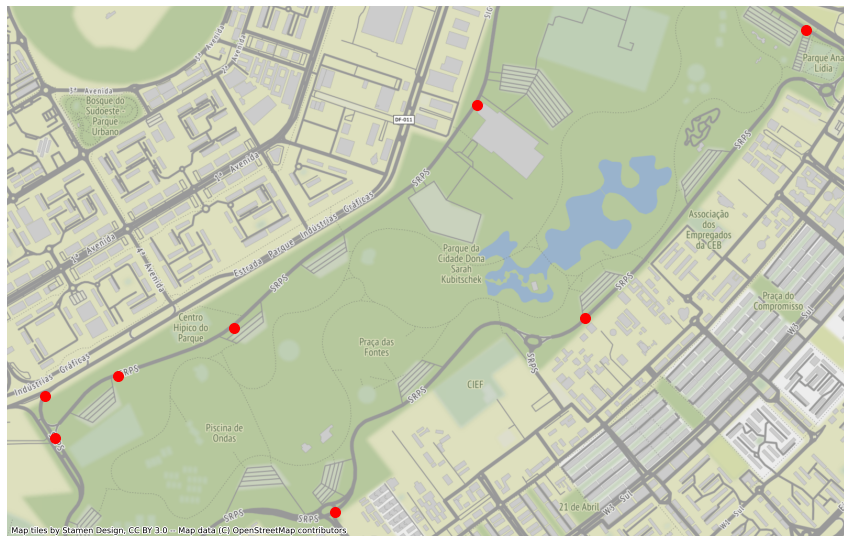

In [21]:
import matplotlib.pyplot as plt
ax = geo_pdc.plot(figsize=(15, 22), markersize=100, color='red', legend=True)
contextily.add_basemap(ax) #biblioteca que dá um contexto pro mapa (um fundo) 
ax.set_axis_off()
plt.show()

In [22]:
pdc_folium = geo_pdc.copy()
accidents = pdc_folium[['latitude', 'longitude']]
locationlist = accidents.values.tolist()
len(locationlist)
locationlist[0]

[-15.792456, -47.896588]

In [23]:
pdc_folium = pdc_folium.reset_index()

Crases visualization - Interative map

In [24]:
park_center = [-15.804051955,	-47.90995495]
mapa = folium.Map(location=park_center, zoom_start=14)

for point in range(0, len(locationlist)):
    folium.Marker(locationlist[point], 
                  popup=pdc_folium['Veiculo'][point], 
                  icon=folium.Icon(color='red')).add_to(mapa)

#mapa.save('accidents_pdc.html')

mapa

#K-means - Andy




In [25]:
df = pd.read_excel("/content/drive/MyDrive/MSc/park_analysis4_total.xlsx")

In [26]:
# dfgy = pd.read_excel("/content/drive/MyDrive/MSc/park4_gy.xlsx")

In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 161 entries, 0 to 160
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   latitude      161 non-null    float64
 1   longitude     161 non-null    float64
 2   accex         161 non-null    float64
 3   accey         161 non-null    float64
 4   accez         161 non-null    float64
 5   climb         161 non-null    float64
 6   gyrox         161 non-null    float64
 7   gyroy         161 non-null    float64
 8   gyroz         161 non-null    float64
 9    us_lpd_left  161 non-null    float64
 10  speed         161 non-null    float64
dtypes: float64(11)
memory usage: 14.0 KB


In [28]:
pck = df.copy()

In [29]:
# pgy = dfgy.copy()

In [30]:
pck.head(2)

,latitude,longitude,accex,accey,accez,climb,gyrox,gyroy,gyroz,us_lpd_left,speed
0,-15.804338,-47.910262,2.810793,0.689530,2.487576,0.195,49.954198,0.290076,-14.366412,189.04,9.062
1,-15.797828,-47.911870,-0.062249,6.449979,19.612701,0.190,55.763359,7.351145,-10.389313,160.03,6.722


In [31]:
pck.rename(columns = {' us_lpd_left':'us_lpd'}, inplace = True)

In [32]:
def optimise_k_means(data, max_k):
    means = []
    inertias = []
    
    for k in range(1,max_k):
        kmeans = KMeans(n_clusters=k, random_state=42, init='k-means++', n_init=10)
        kmeans.fit(data)
        means.append(k)
        inertias.append(kmeans.inertia_)
        
 #Generating the       
    fig = plt.subplots(figsize=(10, 5))
    plt.plot(means, inertias, 'o-')
    plt.xlabel("Number of Clusters")
    plt.ylabel("Inertia")
    plt.title('Elbow Method For Optimal number of Clusters')
    plt.grid(True)
    plt.show()

In [33]:
pck.head()

,latitude,longitude,accex,accey,accez,climb,gyrox,gyroy,gyroz,us_lpd,speed
0,-15.804338,-47.910262,2.810793,0.689530,2.487576,0.195,49.954198,0.290076,-14.366412,189.04,9.062
1,-15.797828,-47.911870,-0.062249,6.449979,19.612701,0.190,55.763359,7.351145,-10.389313,160.03,6.722
2,-15.808282,-47.926879,0.423774,8.176199,-5.906495,0.147,-8.717557,-1.816794,-10.396947,65.30,3.850
3,-15.791270,-47.909070,5.164293,8.135497,-5.066131,0.138,19.106870,13.541985,0.824427,140.94,4.424
4,-15.799999,-47.914681,3.617639,8.690952,-2.391807,0.138,-0.664122,-5.297710,7.038168,223.68,6.653


In [34]:
scaler = StandardScaler()
# scaler = StandaMinMaxScaler() quando der erro de que os valores são de grandezas diferente'
# pck[['climb_t', 'us_lpd_t', 'speed_t']] = scaler.fit_transform(pck[['climb', 'us_lpd', 'speed']])
pck[['climb_t', 'us_lpd_t', 'speed_t', 
     'accex_t', 'accey_t', 'accez_t', 
     'gyrox_t', 'gyroy_t', 'gyroz_t']] = scaler.fit_transform(pck[['climb', 'us_lpd', 'speed', 
                                                                   'accex', 'accey', 'accez', 
                                                                   'gyrox', 'gyroy', 'gyroz']])
pck.head()

,latitude,longitude,accex,accey,accez,climb,gyrox,gyroy,gyroz,us_lpd,speed,climb_t,us_lpd_t,speed_t,accex_t,accey_t,accez_t,gyrox_t,gyroy_t,gyroz_t
0,-15.804338,-47.910262,2.810793,0.689530,2.487576,0.195,49.954198,0.290076,-14.366412,189.04,9.062,2.536422,-0.455006,1.008683,0.193596,-1.409379,1.247691,0.988174,0.091380,-0.560152
1,-15.797828,-47.911870,-0.062249,6.449979,19.612701,0.190,55.763359,7.351145,-10.389313,160.03,6.722,2.473431,-0.642280,-0.130286,-0.426136,-0.294556,4.819251,1.112933,0.492394,-0.372804
2,-15.808282,-47.926879,0.423774,8.176199,-5.906495,0.147,-8.717557,-1.816794,-10.396947,65.30,3.850,1.931700,-1.253808,-1.528199,-0.321298,0.039520,-0.502948,-0.271872,-0.028274,-0.373164
3,-15.791270,-47.909070,5.164293,8.135497,-5.066131,0.138,19.106870,13.541985,0.824427,140.94,4.424,1.818315,-0.765515,-1.248811,0.701260,0.031643,-0.327685,0.325691,0.843985,0.155438
4,-15.799999,-47.914681,3.617639,8.690952,-2.391807,0.138,-0.664122,-5.297710,7.038168,223.68,6.653,1.818315,-0.231388,-0.163871,0.367637,0.139141,0.230063,-0.098915,-0.225963,0.448147


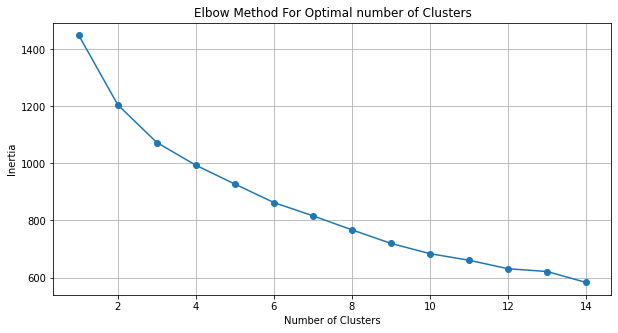

In [35]:
# optimise_k_means(pck[['us_lpd_t', 'speed_t']], 15)
optimise_k_means(pck[['climb_t', 'us_lpd_t', 'speed_t', 'accex_t', 'accey_t', 'accez_t', 'gyrox_t', 'gyroy_t', 'gyroz_t']], 15)
# #plt.axvline(3, linestyle='--', color='r') = ver no notebok Bike itau

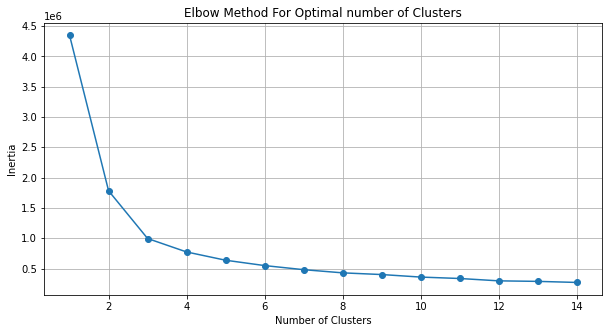

In [36]:
optimise_k_means(pck[['accex', 'accey', 'accez', 'gyrox', 'gyroy', 'gyroz', 'climb', 'us_lpd', 'speed']], 15)
# optimise_k_means(pck[['climb', 'us_lpd', 'speed']], 15)

In the plot above, we can see that the inertia (sum of the squared distances to the nearest cluster center) decreases as we increase the number of clusters. There is no clear defined break within this dataset, however, we can see that the slope changes from about 4 (3 to 5) clusters onwards.

In [37]:
# random_state=10 - forma como estava

from sklearn.metrics import silhouette_samples, silhouette_score

range_n_clusters = [2, 3, 4, 5, 6, 7, 8, 9, 10, 15]
silscore = []
X2 = pck[['climb_t', 'us_lpd_t', 'speed_t', 'accex_t', 'accey_t', 'accez_t', 'gyrox_t', 'gyroy_t', 'gyroz_t']].copy()

for n_clusters in range_n_clusters:
    clusterer = KMeans(n_clusters=n_clusters, random_state=10, init='k-means++', n_init=10)
    cluster_labels = clusterer.fit_predict(X2)
    silhouette_avg = silhouette_score(X2, cluster_labels)
    silscore.append(silhouette_avg)
    print("For n_clusters =", n_clusters,",","The average silhouette_score is :", silhouette_avg)
    sample_silhouette_values = silhouette_samples(X2, cluster_labels)

For n_clusters = 2 , The average silhouette_score is : 0.1496322051380347
For n_clusters = 3 , The average silhouette_score is : 0.1373810613722346
For n_clusters = 4 , The average silhouette_score is : 0.1335622825469365
For n_clusters = 5 , The average silhouette_score is : 0.11906506152453945
For n_clusters = 6 , The average silhouette_score is : 0.1017479904810742
For n_clusters = 7 , The average silhouette_score is : 0.12336039022830236
For n_clusters = 8 , The average silhouette_score is : 0.11294442496204284
For n_clusters = 9 , The average silhouette_score is : 0.11252040848623253
For n_clusters = 10 , The average silhouette_score is : 0.13343487289993053
For n_clusters = 15 , The average silhouette_score is : 0.11902445668169791


In [38]:
# random_state=42 - nova proposta

from sklearn.metrics import silhouette_samples, silhouette_score

range_n_clusters = [2, 3, 4, 5, 6, 7, 8, 9, 10, 15]
silscore = []
X2 = pck[['climb_t', 'us_lpd_t', 'speed_t', 'accex_t', 'accey_t', 'accez_t', 'gyrox_t', 'gyroy_t', 'gyroz_t']].copy()

for n_clusters in range_n_clusters:
    clusterer = KMeans(n_clusters=n_clusters, random_state=42, init='k-means++', n_init=10)
    cluster_labels = clusterer.fit_predict(X2)
    silhouette_avg = silhouette_score(X2, cluster_labels)
    silscore.append(silhouette_avg)
    print("For n_clusters =", n_clusters,",","The average silhouette_score is :", silhouette_avg)
    sample_silhouette_values = silhouette_samples(X2, cluster_labels)

For n_clusters = 2 , The average silhouette_score is : 0.1496322051380347
For n_clusters = 3 , The average silhouette_score is : 0.13560743095900377
For n_clusters = 4 , The average silhouette_score is : 0.10094280267890506
For n_clusters = 5 , The average silhouette_score is : 0.12763078176686712
For n_clusters = 6 , The average silhouette_score is : 0.12432540987846895
For n_clusters = 7 , The average silhouette_score is : 0.11960709185821396
For n_clusters = 8 , The average silhouette_score is : 0.13109587751942597
For n_clusters = 9 , The average silhouette_score is : 0.12851711254586987
For n_clusters = 10 , The average silhouette_score is : 0.12219200060421012
For n_clusters = 15 , The average silhouette_score is : 0.11758674484153557


Fititting the clustering models

In [39]:
# kmeans = KMeans(n_clusters=2)
# kmeans.fit(pck[['accex_t', 'accey_t', 'accez_T', 'gyrox_t', 'gyroy_t', 'gyroz_t', 'climb_t', 'us_lpd_t', 'speed_t']])
# #X['cluster_label'] = kmeans.fit_predict(X)
# #centers = kmeans.cluster_centers_ 
# #labels = kmeans.predict(df[['Latitude', 'Longitude', 'Usreading R']])

# kmeans.cluster_centers_

In [40]:
# centers = kmeans.cluster_centers_
# centers

In [41]:
for k in range(2,7):
  kmeans=KMeans(n_clusters=k, random_state=42, init='k-means++', n_init=10)
  kmeans.fit(pck[['climb_t', 'us_lpd_t', 'speed_t', 'accex_t', 'accey_t', 'accez_t', 'gyrox_t', 'gyroy_t', 'gyroz_t']])
  pck[f'KMeans_{k}'] = kmeans.labels_

In [42]:
pck.head()

,latitude,longitude,accex,accey,accez,climb,gyrox,gyroy,gyroz,us_lpd,...,accey_t,accez_t,gyrox_t,gyroy_t,gyroz_t,KMeans_2,KMeans_3,KMeans_4,KMeans_5,KMeans_6
0,-15.804338,-47.910262,2.810793,0.689530,2.487576,0.195,49.954198,0.290076,-14.366412,189.04,...,-1.409379,1.247691,0.988174,0.091380,-0.560152,0,0,2,0,0
1,-15.797828,-47.911870,-0.062249,6.449979,19.612701,0.190,55.763359,7.351145,-10.389313,160.03,...,-0.294556,4.819251,1.112933,0.492394,-0.372804,0,1,0,0,0
2,-15.808282,-47.926879,0.423774,8.176199,-5.906495,0.147,-8.717557,-1.816794,-10.396947,65.30,...,0.039520,-0.502948,-0.271872,-0.028274,-0.373164,0,1,0,1,1
3,-15.791270,-47.909070,5.164293,8.135497,-5.066131,0.138,19.106870,13.541985,0.824427,140.94,...,0.031643,-0.327685,0.325691,0.843985,0.155438,0,1,0,1,1
4,-15.799999,-47.914681,3.617639,8.690952,-2.391807,0.138,-0.664122,-5.297710,7.038168,223.68,...,0.139141,0.230063,-0.098915,-0.225963,0.448147,0,1,0,1,1


In [43]:
#X.plot.scatter(x = 'Latitude', y = 'Longitude', c=labels, s=50f, cmap='viridis')
#plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5)

In [44]:
#matplotlib
# plt.scatter(y=pc['latitude'], x=pc['longitude'], c=pc['KMeans_4'])
# plt.show()

## K-means Cluster Representation

In [45]:
#plotly
# pck["KMeans_3"] = pck["KMeans_3"].astype(float) #convert to string
figkmeans = px.scatter(y=pck['latitude'], 
                       x=pck['longitude'], 
                       size=pck['us_lpd'], 
                       color=pck['KMeans_3'],
                       color_continuous_scale=[(0.00, "blue"),
                                               (0.33, "blue"),
                                               (0.33, "red"), 
                                               (0.66, "red"),
                                               (0.66, "orange"),  
                                               (1.00, "orange")], size_max=25)

figkmeans.update_layout(title={'text':'K-Means Cluster Analysis',
                               'y':0.95,
                               'x':0.5,
                               'xanchor': 'center',
                               'yanchor': 'top'},
                         xaxis_title="Longitude",
                         yaxis_title="Latitude")

# contextily.add_basemap(ax)
# # fignew.set_axis_off()
figkmeans.show()

In [46]:
pck_k0 = pck[pck['KMeans_3'] == 1].drop(columns=['climb_t', 'us_lpd_t', 'speed_t', 'accex_t', 'accey_t', 'accez_t', 'gyrox_t', 'gyroy_t', 'gyroz_t', 'KMeans_2', 'KMeans_4', 'KMeans_5', 'KMeans_6'])
pck_k1 = pck[pck['KMeans_3'] == 2].drop(columns=['climb_t', 'us_lpd_t', 'speed_t', 'accex_t', 'accey_t', 'accez_t', 'gyrox_t', 'gyroy_t', 'gyroz_t', 'KMeans_2', 'KMeans_4', 'KMeans_5', 'KMeans_6'])
pck_k2 = pck[pck['KMeans_3'] == 0].drop(columns=['climb_t', 'us_lpd_t', 'speed_t', 'accex_t', 'accey_t', 'accez_t', 'gyrox_t', 'gyroy_t', 'gyroz_t', 'KMeans_2', 'KMeans_4', 'KMeans_5', 'KMeans_6'])

In [47]:
fignew0 = px.scatter(y=pck_k0['latitude'], 
                    x=pck_k0['longitude'], 
                    size=pck_k0['us_lpd'], 
                    color=pck_k0['KMeans_3'], 
                    color_continuous_scale=[(0.00, "red"),
                                            (1.00, "red")], size_max=30)

fignew0.update_layout(title={'text':'Cluster Analysis',
                            'y':0.95,
                            'x':0.5,
                            'xanchor': 'center',
                            'yanchor': 'top'},
                    xaxis_title="Longitude",
                    yaxis_title="Latitude")
fignew0.show()

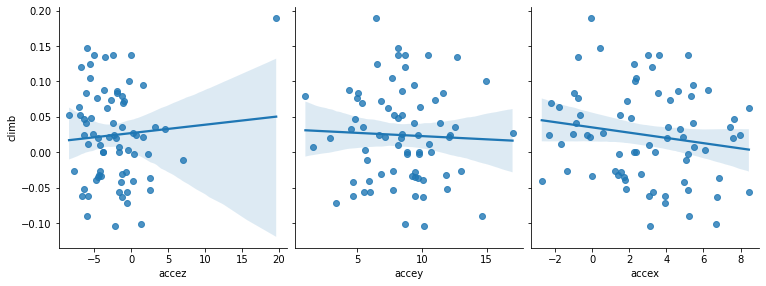

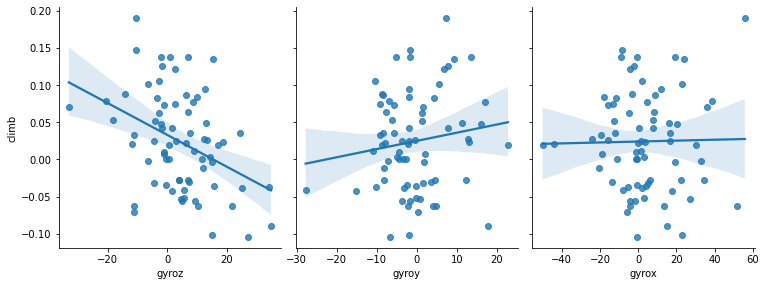

In [48]:
sns.pairplot(pck_k0, x_vars=["accez",'accey',"accex"], y_vars=["climb"], height=4, aspect=.9, kind="reg");
sns.pairplot(pck_k0, x_vars=["gyroz",'gyroy',"gyrox"], y_vars=["climb"], height=4, aspect=.9, kind="reg");

In [49]:
fignew1 = px.scatter(y=pck_k1['latitude'], 
                    x=pck_k1['longitude'], 
                    size=pck_k1['us_lpd'], 
                    color=pck_k1['KMeans_3'], 
                    color_continuous_scale=[(0.00, "blue"),
                                            (0.33, "blue"),
                                            (0.33, "orange"), 
                                            (0.66, "orange"),
                                            (0.66, "red"),  
                                            (1.00, "red")], size_max=30)

fignew1.update_layout(title={'text':'Cluster Analysis',
                            'y':0.95,
                            'x':0.5,
                            'xanchor': 'center',
                            'yanchor': 'top'},
                    xaxis_title="Longitude",
                    yaxis_title="Latitude")
fignew1.show()

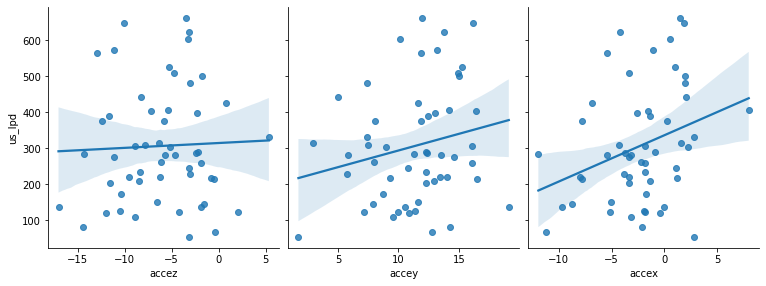

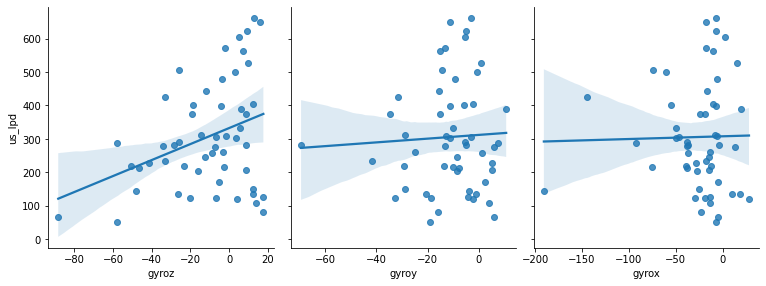

In [50]:
sns.pairplot(pck_k1, x_vars=["accez",'accey',"accex"], y_vars=["us_lpd"], height=4, aspect=.9, kind="reg");
sns.pairplot(pck_k1, x_vars=["gyroz",'gyroy',"gyrox"], y_vars=["us_lpd"], height=4, aspect=.9, kind="reg");

In [51]:
fignew2 = px.scatter(y=pck_k2['latitude'], 
                    x=pck_k2['longitude'], 
                    size=pck_k2['us_lpd'], 
                    color=pck_k2['KMeans_3'], 
                    color_continuous_scale=[(0.00, "blue"),
                                            (1.00, "blue"),
                                            ], size_max=30)
fignew2.update_layout(title={'text':'Cluster Analysis',
                            'y':0.95,
                            'x':0.5,
                            'xanchor': 'center',
                            'yanchor': 'top'},
                    xaxis_title="Longitude",
                    yaxis_title="Latitude")
fignew2.show()

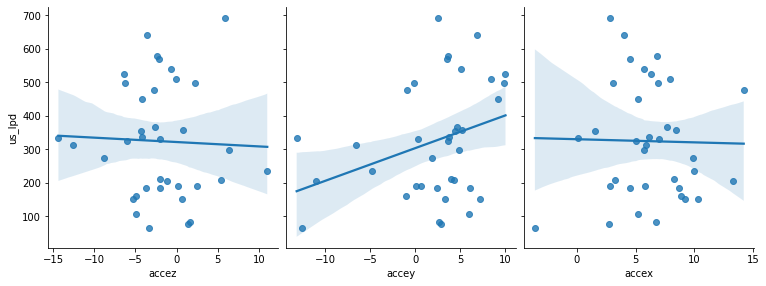

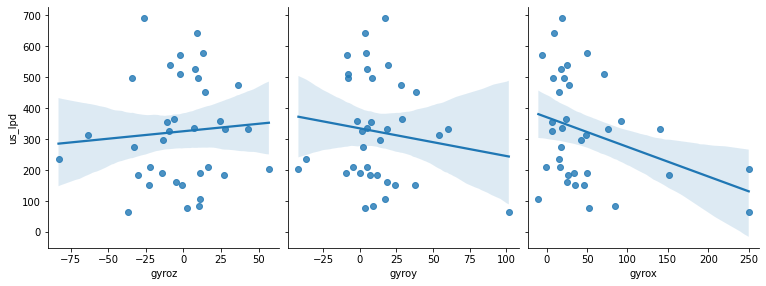

In [52]:
sns.pairplot(pck_k2, x_vars=["accez",'accey',"accex"], y_vars=["us_lpd"], height=4, aspect=.9, kind="reg");
sns.pairplot(pck_k2, x_vars=["gyroz",'gyroy',"gyrox"], y_vars=["us_lpd"], height=4, aspect=.9, kind="reg");

In [53]:
pck_k0.describe().round(4)

,latitude,longitude,accex,accey,accez,climb,gyrox,gyroy,gyroz,us_lpd,speed,KMeans_3
count,72.0000,72.0000,72.0000,72.0000,72.0000,72.0000,72.0000,72.0000,72.0000,72.0000,72.0000,72.0
mean,-15.8011,-47.9134,2.9157,8.3974,-2.3212,0.0243,3.6650,-0.6181,4.0567,193.2772,5.7510,1.0
std,0.0073,0.0092,2.8801,3.0325,4.0915,0.0660,18.8169,8.4589,12.0283,112.2593,1.9634,0.0
min,-15.8142,-47.9269,-2.7270,1.0032,-8.3869,-0.1040,-50.0534,-27.7405,-33.0916,2.5800,0.0000,1.0
25%,-15.8057,-47.9236,1.0415,6.3392,-5.2690,-0.0305,-6.3034,-6.3779,-2.2481,91.0725,4.7798,1.0
50%,-15.8021,-47.9102,3.0574,8.4432,-2.4050,0.0230,1.3206,-1.9313,3.8931,177.2250,5.8245,1.0
75%,-15.7948,-47.9080,5.1445,10.0682,-0.5926,0.0732,16.1660,4.0324,11.8950,287.6550,7.1090,1.0
max,-15.7893,-47.8960,8.4491,16.9916,19.6127,0.1900,55.7634,22.7328,34.8855,434.2000,8.9070,1.0


In [54]:
pck_k1.describe().round(4)

,latitude,longitude,accex,accey,accez,climb,gyrox,gyroy,gyroz,us_lpd,speed,KMeans_3
count,53.0000,53.0000,53.0000,53.0000,53.0000,53.0000,53.0000,53.0000,53.0000,53.0000,53.0000,53.0
mean,-15.8018,-47.9113,-2.3197,11.3586,-6.0907,-0.0483,-26.0879,-11.2686,-11.1473,305.7340,7.8726,2.0
std,0.0080,0.0099,3.8796,3.6028,4.6270,0.0710,37.4534,14.2901,23.1627,161.3258,1.6440,0.0
min,-15.8141,-47.9267,-11.9471,1.7358,-17.0300,-0.2450,-190.6412,-69.2901,-88.2672,52.9600,4.1780,2.0
25%,-15.8075,-47.9206,-4.2042,8.9926,-9.5624,-0.0880,-37.5802,-15.7252,-25.7710,203.2900,6.8430,2.0
50%,-15.8029,-47.9124,-1.8747,11.8681,-5.6671,-0.0520,-17.6870,-9.3359,-5.2519,281.2800,8.3160,2.0
75%,-15.7944,-47.9015,0.5171,13.7810,-3.0478,-0.0120,-6.7405,-2.4122,6.9847,401.9600,9.1220,2.0
max,-15.7893,-47.8955,7.9966,19.1177,5.3367,0.1340,28.1756,10.6107,17.7405,663.0300,10.6260,2.0


In [55]:
pck_k2.describe().round(4)

,latitude,longitude,accex,accey,accez,climb,gyrox,gyroy,gyroz,us_lpd,speed,KMeans_3
count,36.0000,36.0000,36.0000,36.0000,36.0000,36.0000,36.0000,36.0000,36.0000,36.0000,36.0000,36.0
mean,-15.7994,-47.9062,6.1404,2.1353,-2.0210,-0.0058,48.7053,11.9275,-2.7721,323.9847,8.1672,0.0
std,0.0062,0.0077,3.4778,5.6654,4.9718,0.0897,61.1907,25.4215,27.9397,172.0910,1.3484,0.0
min,-15.8126,-47.9250,-3.5889,-13.1585,-14.3580,-0.1990,-10.3969,-41.9618,-82.9771,63.5400,5.6230,0.0
25%,-15.8042,-47.9107,4.4047,0.2131,-4.4472,-0.0688,16.2710,1.0973,-16.3454,187.7350,7.5275,0.0
50%,-15.7998,-47.9037,6.0298,3.5386,-2.2410,0.0105,25.9733,7.0916,-1.5763,318.5650,8.1880,0.0
75%,-15.7940,-47.9010,8.2971,5.1236,0.6919,0.0580,50.7004,18.6813,11.5057,480.8100,9.1773,0.0
max,-15.7893,-47.8962,14.2240,10.0149,11.0325,0.1950,250.1298,101.7176,56.7710,693.1700,10.2570,0.0


###Cluster distribution comparation

<ipython-input-56-25c7613eea74>:4: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751


<ipython-input-56-25c7613eea74>:5: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751


<ipython-input-56-25c7613eea74>:6: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use ei

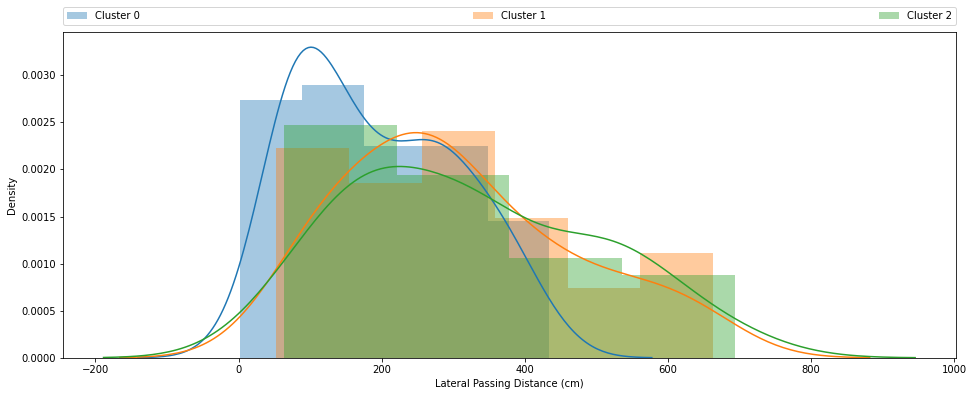

In [56]:
f, axes = plt.subplots(figsize=(16,6))
sns.set_palette('colorblind')

ax = sns.distplot(pck_k0['us_lpd'],label='Cluster 0')
ax1 = sns.distplot(pck_k1['us_lpd'],label='Cluster 1')
ax2 = sns.distplot(pck_k2['us_lpd'], label='Cluster 2')

ax1.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3, mode="expand", borderaxespad=0.)
ax.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3, ncol=4, mode="expand", borderaxespad=0.)

ax1.set_xlabel("Lateral Passing Distance (cm)")
plt.ylabel('Density')

plt.show()

In [57]:
pd.options.display.float_format = "{:,.2f}".format

# Resumo estatístico da distribuíção da duração das viagens
resumo = pd.DataFrame(data=[pck_k0['us_lpd'].describe(),
                            pck_k1['us_lpd'].describe(),
                            pck_k2['us_lpd'].describe()],
                      index=['Cluster 0','Cluster 1','Cluster 2'])

resumo.columns = ['samples','mean','std','min','25%','50%','75%','max']
resumo

,samples,mean,std,min,25%,50%,75%,max
Cluster 0,72.00,193.28,112.26,2.58,91.07,177.23,287.66,434.20
Cluster 1,53.00,305.73,161.33,52.96,203.29,281.28,401.96,663.03
Cluster 2,36.00,323.98,172.09,63.54,187.73,318.56,480.81,693.17


In [58]:
# Teste KS para comparar as distribuições - Performs the two-sample Kolmogorov-Smirnov test for goodness of fit.
from scipy import stats
print('KS test: {}'.format(stats.ks_2samp(pck_k0['us_lpd'], pck_k1['us_lpd'])))
print('KS test: {}'.format(stats.ks_2samp(pck_k1['us_lpd'], pck_k2['us_lpd'])))
print('KS test: {}'.format(stats.ks_2samp(pck_k0['us_lpd'], pck_k2['us_lpd'])))

KS test: KstestResult(statistic=0.31027253668763105, pvalue=0.004089742487441905, statistic_location=193.69, statistic_sign=1)
KS test: KstestResult(statistic=0.15041928721174005, pvalue=0.6504828182339926, statistic_location=309.78, statistic_sign=1)
KS test: KstestResult(statistic=0.3611111111111111, pvalue=0.00325096238823988, statistic_location=303.85, statistic_sign=1)


In [59]:
print('Teste KS: {}'.format(stats.ks_2samp(pck_k0['climb'], pck_k1['climb'])))
print('Teste KS: {}'.format(stats.ks_2samp(pck_k1['climb'], pck_k2['climb'])))
print('Teste KS: {}'.format(stats.ks_2samp(pck_k0['climb'], pck_k2['climb'])))

Teste KS: KstestResult(statistic=0.4730083857442348, pvalue=1.000921396539706e-06, statistic_location=-0.01, statistic_sign=-1)
Teste KS: KstestResult(statistic=0.38469601677148846, pvalue=0.002264969000389373, statistic_location=-0.012, statistic_sign=1)
Teste KS: KstestResult(statistic=0.2638888888888889, pvalue=0.06622951404062484, statistic_location=-0.056, statistic_sign=-1)


In [60]:
# from scipy.stats import f_oneway

# cluster_groups = [pck.loc[pck['KMeans_3']==0, 'us_lpd'].values for arm in pck['KMeans_3'].dropna().unique()]
# stat, p_value = f_oneway(*cluster_groups)
# print(f"F Test: statistic={stat:.4f}, p-value={p_value:.4f}")

In [61]:
from scipy.stats import f_oneway
k0 = pck_k0[['accex','accey','accez','climb','gyrox','gyroy','gyroz','us_lpd','speed']]
k1 = pck_k1[['accex','accey','accez','climb','gyrox','gyroy','gyroz','us_lpd','speed']]
k2 = pck_k2[['accex','accey','accez','climb','gyrox','gyroy','gyroz','us_lpd','speed']]

ANOVA = f_oneway(k0, k1, k2, axis=0)
ANOVA

F_onewayResult(statistic=array([73.2919095 , 59.53548958, 13.33344521, 14.90184652, 41.35106575,
       23.9135814 ,  8.517297  , 13.91952854, 33.34328441]), pvalue=array([3.02740468e-23, 5.36065366e-20, 4.45836896e-06, 1.17837562e-06,
       3.60574421e-15, 8.45663428e-10, 3.06988733e-04, 2.70450259e-06,
       8.30458635e-13]))


os centros estão vindo escalados - ver possibilidade de listas eles sem a escala normalizada

In [62]:
centers = kmeans.cluster_centers_
centers

array([[ 0.74745194, -0.32209712,  0.08026352,  0.75205555, -1.21791562,
         0.92622281,  0.50733667,  0.32790092, -1.33597353],
       [ 0.48752739, -0.38085435, -0.82171945, -0.09393643,  0.24298817,
        -0.2207412 , -0.15363676,  0.03505958,  0.18134123],
       [ 0.14692898,  1.57429477,  0.60951655,  0.39141509,  0.10498777,
         0.05405057,  0.18492726,  0.41430467,  0.41335592],
       [-0.73495789,  0.12513748,  0.5919534 , -1.30849729,  0.71618269,
        -0.54702232, -0.86371927, -0.82845133, -0.82816846],
       [-0.54025559, -0.42970478,  0.2819672 ,  0.72165134, -0.2753621 ,
         0.49948785,  0.2917649 ,  0.11120431,  0.60547387],
       [-0.63417082, -0.37962781,  1.34080093,  0.2906871 , -3.90591494,
        -0.584838  ,  4.49988803,  1.55049218,  1.10368435]])

parentesis para ver centros de diferentes clusters

In [63]:
#   #Para ver os centros do caso pontual de n clusters

# kmeans = KMeans(n_clusters=3)
# kmeans.fit(pck[['accex_t', 'accey_t', 'accez_T', 'gyrox_t', 'gyroy_t', 'gyroz_t', 'climb_t', 'us_lpd_t', 'speed_t']])
# #X['cluster_label'] = kmeans.fit_predict(X)
# #centers = kmeans.cluster_centers_ 
# #labels = kmeans.predict(df[['Latitude', 'Longitude', 'Usreading R']])

# kmeans.cluster_centers_

In [64]:
# kmeans.fit(pck[['accex_t', 'accey_t', 'accez_t', 'gyrox_t', 'gyroy_t', 'gyroz_t', 'climb_t', 'us_lpd_t', 'speed_t']])

In [65]:
# from sklear.preprocessing import OrdinalEncoder

# oe = OrdinalEncoder()
# X = or.fit_transform(X)

In [66]:
kmeans.cluster_centers_

array([[ 0.74745194, -0.32209712,  0.08026352,  0.75205555, -1.21791562,
         0.92622281,  0.50733667,  0.32790092, -1.33597353],
       [ 0.48752739, -0.38085435, -0.82171945, -0.09393643,  0.24298817,
        -0.2207412 , -0.15363676,  0.03505958,  0.18134123],
       [ 0.14692898,  1.57429477,  0.60951655,  0.39141509,  0.10498777,
         0.05405057,  0.18492726,  0.41430467,  0.41335592],
       [-0.73495789,  0.12513748,  0.5919534 , -1.30849729,  0.71618269,
        -0.54702232, -0.86371927, -0.82845133, -0.82816846],
       [-0.54025559, -0.42970478,  0.2819672 ,  0.72165134, -0.2753621 ,
         0.49948785,  0.2917649 ,  0.11120431,  0.60547387],
       [-0.63417082, -0.37962781,  1.34080093,  0.2906871 , -3.90591494,
        -0.584838  ,  4.49988803,  1.55049218,  1.10368435]])

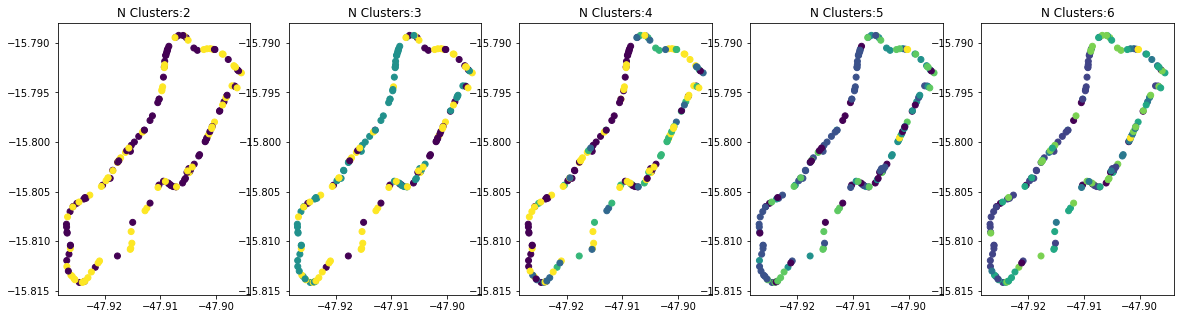

In [67]:
fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(20,5))
#plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5)
for i, ax in enumerate(fig.axes, start=2):
    ax.scatter(y=pck['latitude'], x=pck['longitude'], c=pck[f'KMeans_{i}'])
    ax.set_title(f'N Clusters:{i}')

silhouette score for k-means

In [68]:
pck['KMeans_3'].describe()

count   161.00
mean      1.11
std       0.74
min       0.00
25%       1.00
50%       1.00
75%       2.00
max       2.00
Name: KMeans_3, dtype: float64

In [69]:
pck[['us_lpd','speed', 'climb']].describe()

,us_lpd,speed,climb
count,161.00,161.00,161.00
mean,259.52,6.99,-0.01
std,155.39,2.06,0.08
min,2.58,0.00,-0.24
25%,136.36,5.55,-0.06
50%,235.97,7.32,-0.01
75%,350.22,8.61,0.05
max,693.17,10.63,0.20


###Feature Silhouette Analysis

In [70]:
from sklearn import metrics

  #total
X2 = pck[['climb_t', 'us_lpd_t', 'speed_t', 'accex_t', 'accey_t', 'accez_t', 'gyrox_t', 'gyroy_t', 'gyroz_t']]
kmeans_model = KMeans(n_clusters=3, random_state=42, init='k-means++', n_init=10).fit(X2)
labels = kmeans_model.labels_
metrics.silhouette_score(X2, labels, metric='euclidean')

0.13560743095900377

In [71]:
  #3 + acce

X3 = pck[['climb_t', 'us_lpd_t', 'speed_t', 'accex_t', 'accey_t', 'accez_t']]
kmeans_model = KMeans(n_clusters=3, random_state=42, init='k-means++', n_init=10).fit(X3)
labels = kmeans_model.labels_
metrics.silhouette_score(X3, labels, metric='euclidean')

0.1615005340590855

In [72]:
  #3 + gyro

X7 = pck[['climb_t', 'us_lpd_t', 'speed_t', 'gyrox_t', 'gyroy_t', 'gyroz_t']]
kmeans_model = KMeans(n_clusters=3, random_state=42, init='k-means++', n_init=10).fit(X7)
labels = kmeans_model.labels_
metrics.silhouette_score(X7, labels, metric='euclidean')

0.19070782205619874

In [73]:
  #3 = n_clusters ruim

X4 = pck[['climb_t', 'us_lpd_t', 'speed_t']]
kmeans_model = KMeans(n_clusters=3, random_state=42, init='k-means++', n_init=10).fit(X4)
labels = kmeans_model.labels_
metrics.silhouette_score(X4, labels, metric='euclidean')

0.25815048892680814

In [74]:
X5 = pck[['climb_t', 'us_lpd_t']]
kmeans_model = KMeans(n_clusters=3, random_state=42, init='k-means++', n_init=10).fit(X5)
labels = kmeans_model.labels_
metrics.silhouette_score(X5, labels, metric='euclidean')

0.35244390791974306

In [75]:
X6 = pck[['speed_t', 'us_lpd_t']]
kmeans_model = KMeans(n_clusters=3, random_state=42, init='k-means++', n_init=10).fit(X6)
labels = kmeans_model.labels_
metrics.silhouette_score(X6, labels, metric='euclidean')

0.3870782334632896

### PCA test

In [76]:
import numpy as np
from sklearn.decomposition import PCA

X = np.array(pck[['climb_t', 'speed_t', 'accex_t', 'accey_t', 'accez_t', 'gyrox_t', 'gyroy_t', 'gyroz_t', 'us_lpd_t']])
pca = PCA(n_components=2)
x = pca.fit_transform(X)

print(pca.explained_variance_ratio_)

[0.28161063 0.15312642]


In [77]:
Xt = np.array(pck[['climb', 'speed', 'accex', 'accey', 'accez', 'gyrox', 'gyroy', 'gyroz','us_lpd']])
pca = PCA(n_components=2)
xt = pca.fit_transform(Xt)

print(pca.explained_variance_ratio_)

[0.88922816 0.0844997 ]


In [78]:
cols = pck[['climb_t', 'us_lpd_t', 'speed_t', 'accex_t', 'accey_t', 'accez_t', 'gyrox_t', 'gyroy_t', 'gyroz_t', 'us_lpd_t']].columns.tolist()


In [79]:
dt = pd.DataFrame(xt)
dt['us_lpd'] = pck['us_lpd_t']

d = pd.DataFrame(xt)
d['us_lpd'] = pck['us_lpd']

<Axes: >

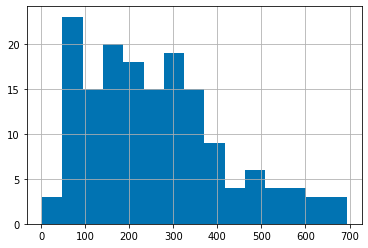

In [80]:
pck['us_lpd'].hist(bins=15)

In [81]:
px.scatter(dt, x=1,y=0, color='us_lpd')

In [82]:
px.scatter(d, x=1,y=0, color='us_lpd', 
           color_continuous_scale=[(0.00, "red"),
                                   (0.33, "red"),
                                   (0.33, "orange"),
                                   (0.66, "orange"),
                                   (0.66, "blue"),
                                   (1.00, "blue")])

In [83]:
c1 = pck[pck['KMeans_3']==0]

####Fim K-means

#*DBSCAN* - Greg

In [84]:
df = pd.read_excel("/content/drive/MyDrive/MSc/park_analysis4_total.xlsx")

In [85]:
pcD = df.copy()

In [86]:
from sklearn.cluster import DBSCAN

In [87]:
pcD.rename(columns = {' us_lpd_left':'us_lpd'}, inplace = True)

In [88]:
# DBSCAN is not sensitive to scalar variation like k-means
# from sklearn.preprocessing import StandardScaler
# scaler = StandardScaler()
# pcD[['climb_t', 'us_lpd_left_t', 'speed_t']] = scaler.fit_transform(pcD[[ 'climb', ' us_lpd_left', 'speed']])
# pcD

In [89]:
pcD.head()

,latitude,longitude,accex,accey,accez,climb,gyrox,gyroy,gyroz,us_lpd,speed
0,-15.80,-47.91,2.81,0.69,2.49,0.20,49.95,0.29,-14.37,189.04,9.06
1,-15.80,-47.91,-0.06,6.45,19.61,0.19,55.76,7.35,-10.39,160.03,6.72
2,-15.81,-47.93,0.42,8.18,-5.91,0.15,-8.72,-1.82,-10.40,65.30,3.85
3,-15.79,-47.91,5.16,8.14,-5.07,0.14,19.11,13.54,0.82,140.94,4.42
4,-15.80,-47.91,3.62,8.69,-2.39,0.14,-0.66,-5.30,7.04,223.68,6.65


In [90]:
lat_long_read = pcD[['latitude','longitude','climb','speed','us_lpd']]
lat, longg, climb, speed, lpd = pcD.latitude, pcD.longitude, pcD.climb, pcD.speed, pcD.us_lpd

# plt.scatter(climb,lpd,speed)

In [91]:
X = pcD[['latitude', 'longitude','climb','speed', 'us_lpd']]

from sklearn.cluster import DBSCAN
X = lat_long_read.to_numpy()

dbscan_cluster_model = DBSCAN(eps=0.00025, min_samples=2).fit(X) 
dbscan_cluster_model

DBSCAN(eps=0.00025, min_samples=2)

In [92]:
pcD['cluster'] = dbscan_cluster_model.labels_
pcD.head()

,latitude,longitude,accex,accey,accez,climb,gyrox,gyroy,gyroz,us_lpd,speed,cluster
0,-15.80,-47.91,2.81,0.69,2.49,0.20,49.95,0.29,-14.37,189.04,9.06,-1
1,-15.80,-47.91,-0.06,6.45,19.61,0.19,55.76,7.35,-10.39,160.03,6.72,-1
2,-15.81,-47.93,0.42,8.18,-5.91,0.15,-8.72,-1.82,-10.40,65.30,3.85,-1
3,-15.79,-47.91,5.16,8.14,-5.07,0.14,19.11,13.54,0.82,140.94,4.42,-1
4,-15.80,-47.91,3.62,8.69,-2.39,0.14,-0.66,-5.30,7.04,223.68,6.65,-1


In [93]:
pcD['cluster'].value_counts()

-1    161
Name: cluster, dtype: int64

https://colab.research.google.com/drive/1DphvjpgQXwBWQq08dMyoSc6UREzXLxSE?usp=sharing#scrollTo=aWZJXk5aXcZX
testar encontrar melhor esp e min_sample

In [94]:
# px.scatter_3d(data_frame=pcD,x=longg, y=lat, z=lpd, color=pcD['cluster'],template='plotly_white',
#              title='3D Scatter plot for KMeans Clusters')

In [95]:
# from sklearn.metrics import silhouette_score as ss
# ss(X, pcD['cluster'])

In [96]:
epsilons = np.linspace(0.01, 1, num=15)
epsilons

array([0.01      , 0.08071429, 0.15142857, 0.22214286, 0.29285714,
       0.36357143, 0.43428571, 0.505     , 0.57571429, 0.64642857,
       0.71714286, 0.78785714, 0.85857143, 0.92928571, 1.        ])

In [97]:
min_samples = np.arange(2, 20, step=3)
min_samples

array([ 2,  5,  8, 11, 14, 17])

In [98]:
import itertools
combinations = list(itertools.product(epsilons, min_samples))
combinations

[(0.01, 2),
 (0.01, 5),
 (0.01, 8),
 (0.01, 11),
 (0.01, 14),
 (0.01, 17),
 (0.08071428571428571, 2),
 (0.08071428571428571, 5),
 (0.08071428571428571, 8),
 (0.08071428571428571, 11),
 (0.08071428571428571, 14),
 (0.08071428571428571, 17),
 (0.15142857142857144, 2),
 (0.15142857142857144, 5),
 (0.15142857142857144, 8),
 (0.15142857142857144, 11),
 (0.15142857142857144, 14),
 (0.15142857142857144, 17),
 (0.22214285714285714, 2),
 (0.22214285714285714, 5),
 (0.22214285714285714, 8),
 (0.22214285714285714, 11),
 (0.22214285714285714, 14),
 (0.22214285714285714, 17),
 (0.29285714285714287, 2),
 (0.29285714285714287, 5),
 (0.29285714285714287, 8),
 (0.29285714285714287, 11),
 (0.29285714285714287, 14),
 (0.29285714285714287, 17),
 (0.3635714285714286, 2),
 (0.3635714285714286, 5),
 (0.3635714285714286, 8),
 (0.3635714285714286, 11),
 (0.3635714285714286, 14),
 (0.3635714285714286, 17),
 (0.4342857142857143, 2),
 (0.4342857142857143, 5),
 (0.4342857142857143, 8),
 (0.4342857142857143, 11),
 

In [99]:
combinations = list(itertools.product(epsilons, min_samples))
N = len(combinations)
N

90

In [100]:
def get_scores_and_labels(combinations, X):
  scores = []
  all_labels_list = []

  for i, (eps, num_samples) in enumerate(combinations):
    dbscan_cluster_model = DBSCAN(eps=eps, min_samples=num_samples).fit(X)
    labels = dbscan_cluster_model.labels_
    labels_set = set(labels)
    num_clusters = len(labels_set)
    if -1 in labels_set:
      num_clusters -= 1
    
    if (num_clusters < 2) or (num_clusters > 50):
      scores.append(-10)
      all_labels_list.append('bad')
      c = (eps, num_samples)
      print(f"Combination {c} on iteration {i+1} of {N} has {num_clusters} clusters. Moving on")
      continue
    
    scores.append(ss(X, labels))
    all_labels_list.append(labels)
    print(f"Index: {i}, Score: {scores[-1]}, Labels: {all_labels_list[-1]}, NumClusters: {num_clusters}")

  best_index = np.argmax(scores)
  best_parameters = combinations[best_index]
  best_labels = all_labels_list[best_index]
  best_score = scores[best_index]

  return {'best_epsilon': best_parameters[0],
          'best_min_samples': best_parameters[1], 
          'best_labels': best_labels,
          'best_score': best_score}

best_dict = get_scores_and_labels(combinations, X)

Combination (0.01, 2) on iteration 1 of 90 has 0 clusters. Moving on
Combination (0.01, 5) on iteration 2 of 90 has 0 clusters. Moving on
Combination (0.01, 8) on iteration 3 of 90 has 0 clusters. Moving on
Combination (0.01, 11) on iteration 4 of 90 has 0 clusters. Moving on
Combination (0.01, 14) on iteration 5 of 90 has 0 clusters. Moving on
Combination (0.01, 17) on iteration 6 of 90 has 0 clusters. Moving on
Combination (0.08071428571428571, 2) on iteration 7 of 90 has 0 clusters. Moving on
Combination (0.08071428571428571, 5) on iteration 8 of 90 has 0 clusters. Moving on
Combination (0.08071428571428571, 8) on iteration 9 of 90 has 0 clusters. Moving on
Combination (0.08071428571428571, 11) on iteration 10 of 90 has 0 clusters. Moving on
Combination (0.08071428571428571, 14) on iteration 11 of 90 has 0 clusters. Moving on
Combination (0.08071428571428571, 17) on iteration 12 of 90 has 0 clusters. Moving on
Combination (0.15142857142857144, 2) on iteration 13 of 90 has 0 clusters

Epsilon, MinSamples and Silhouette Score for DBSCAN

In [101]:
best_dict

{'best_epsilon': 0.4342857142857143,
 'best_min_samples': 2,
 'best_labels': array([-1, -1,  0, -1, -1, -1, -1, -1, -1, -1, -1,  1, -1, -1, -1, -1, -1,
        -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
        -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
        -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
        -1, -1,  0, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
        -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
        -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
        -1, -1, -1,  0, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
        -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
        -1, -1,  1, -1, -1, -1, -1, -1]),
 'best_score': -0.48985380260702777}

Clusters and Noise Points

In [102]:
pcD['cluster'] = best_dict['best_labels']
pcD['cluster'].value_counts()

-1    156
 0      3
 1      2
Name: cluster, dtype: int64

In [103]:
len(set('cluster'))

7

## DBSCAN Representation

In [104]:
figdbscan = px.scatter(x=longg, y=lat, color=pcD['cluster'],
                 color_continuous_scale=[(0.00, "red"),
                                         (0.33, "red"),
                                         (0.33, "orange"), 
                                         (0.66, "orange"),
                                         (0.66, "blue"),  
                                         (1.00, "blue")], size_max=25)

figdbscan.update_layout(title={'text':'DBSCAN Cluster Analysis',
                            'y':0.95,
                            'x':0.5,
                            'xanchor': 'center',
                            'yanchor': 'top'},
                     xaxis_title="Longitude",
                     yaxis_title="Latitude")

figdbscan.show()

Silhouette Score for DBSCAN

In [105]:
ss(X, pcD['cluster'])

-0.48985380260702777

In [106]:
# px.scatter_3d(data_frame=pcD,x=longg, y=lat, z=lpd, color=pcD['cluster'],template='plotly_white',
#              title='3D Scatter plot for KMeans Clusters')

#### Fim DBSCAN

# Correlation Analysis

In [107]:
from collections import defaultdict

import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import spearmanr
from scipy.cluster import hierarchy
from scipy.spatial.distance import squareform

from sklearn.datasets import load_breast_cancer
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split

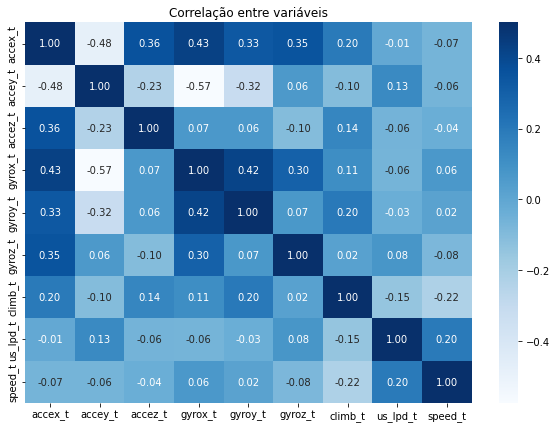

In [108]:
plt.figure(figsize=(10, 7))
sns.heatmap(pck[['accex_t', 'accey_t', 'accez_t', 
                 'gyrox_t', 'gyroy_t', 'gyroz_t', 
                 'climb_t', 'us_lpd_t', 'speed_t']].corr(),
            annot = True,
            vmax=.5,
            fmt = '.2f',
            cmap='Blues')
plt.title('Correlação entre variáveis')
plt.show()

<Axes: >

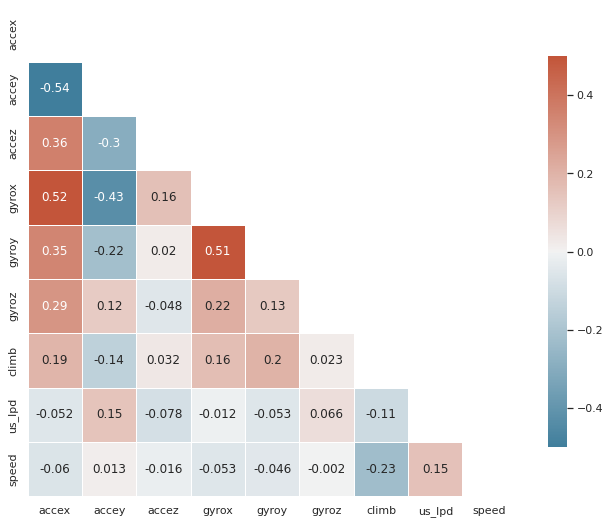

In [109]:
from string import ascii_letters
sns.set_theme(style="white")

# Compute the correlation matrix
corr = pck[['accex', 'accey', 'accez',
            'gyrox', 'gyroy', 'gyroz', 
            'climb', 'us_lpd', 'speed']].corr(method = 'spearman')

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, annot = True, vmax=.5, vmin=-.5, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .8})

<Axes: >

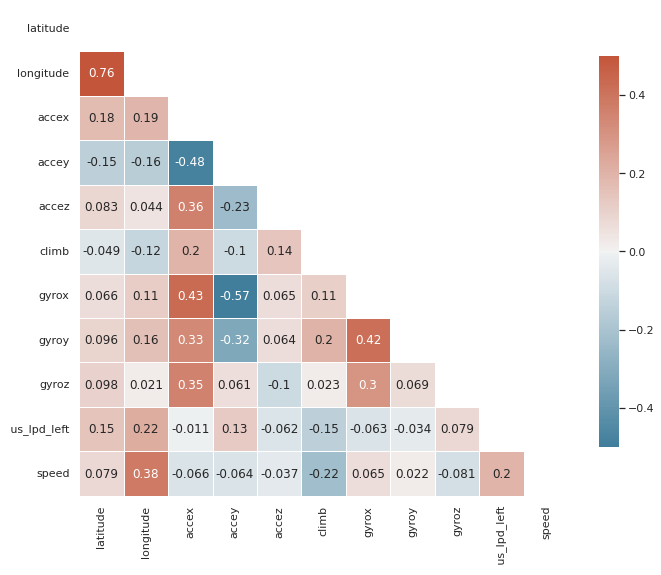

In [110]:
sns.set_theme(style="white")

# Compute the correlation matrix
corr = df.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, annot = True, vmax=.5, vmin=-.5, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .8})

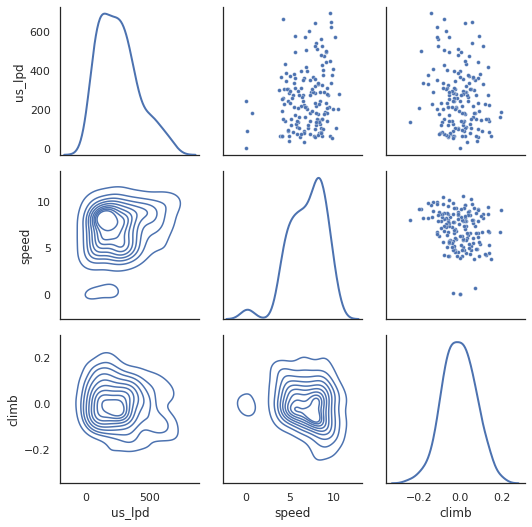

In [111]:
sns.set_theme(style="white")
g = sns.PairGrid(pck[['us_lpd', 'speed', 'climb']], diag_sharey=False)
g.map_upper(sns.scatterplot, s=15)
g.map_lower(sns.kdeplot)
g.map_diag(sns.kdeplot, lw=2)

#Traffic Volume Analysis

In [112]:
volume = pd.read_excel('/content/drive/MyDrive/MSc/pdc_volume.xlsx')

In [113]:
volume.head()

,trecho,latitude,longitude,accey,climb,us_lpd,speed,volume
0,3,-15.81,-47.93,8.18,0.15,65.30,3.85,330
1,3,-15.81,-47.93,10.47,0.14,86.18,5.32,330
2,3,-15.81,-47.93,6.55,0.12,152.27,4.22,330
3,3,-15.81,-47.92,14.97,0.10,145.13,8.38,330
4,3,-15.81,-47.93,9.38,0.10,382.20,5.43,330


In [114]:
volume.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115 entries, 0 to 114
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   trecho     115 non-null    int64  
 1   latitude   115 non-null    float64
 2   longitude  115 non-null    float64
 3   accey      115 non-null    float64
 4   climb      115 non-null    float64
 5    us_lpd    115 non-null    float64
 6   speed      115 non-null    float64
 7   volume     115 non-null    int64  
dtypes: float64(6), int64(2)
memory usage: 7.3 KB


In [115]:
volume_t = volume.copy()
volume_t.head()

,trecho,latitude,longitude,accey,climb,us_lpd,speed,volume
0,3,-15.81,-47.93,8.18,0.15,65.30,3.85,330
1,3,-15.81,-47.93,10.47,0.14,86.18,5.32,330
2,3,-15.81,-47.93,6.55,0.12,152.27,4.22,330
3,3,-15.81,-47.92,14.97,0.10,145.13,8.38,330
4,3,-15.81,-47.93,9.38,0.10,382.20,5.43,330


In [116]:
volume_t.describe()

,trecho,latitude,longitude,accey,climb,us_lpd,speed,volume
count,115.00,115.00,115.00,115.00,115.00,115.00,115.00,115.00
mean,1.67,-15.80,-47.91,8.24,0.01,242.60,6.47,147.50
std,0.77,0.01,0.01,4.48,0.08,142.48,1.85,86.75
min,1.00,-15.81,-47.93,-12.51,-0.24,35.63,0.12,103.00
25%,1.00,-15.81,-47.92,5.67,-0.04,129.39,5.05,103.00
50%,1.00,-15.80,-47.91,8.43,0.01,227.48,6.55,103.00
75%,2.00,-15.80,-47.90,10.76,0.06,325.77,7.86,113.00
max,3.00,-15.79,-47.90,19.12,0.19,648.89,10.63,330.00


In [117]:
scaler = StandardScaler()
volume_t[['accey_t', 'climb_t','us_lpd_t','speed_t', 'volume_t']] = scaler.fit_transform(volume_t[['accey',	'climb',' us_lpd', 'speed',	'volume']])
volume_t.head()

,trecho,latitude,longitude,accey,climb,us_lpd,speed,volume,accey_t,climb_t,us_lpd_t,speed_t,volume_t
0,3,-15.81,-47.93,8.18,0.15,65.30,3.85,330,-0.01,1.79,-1.25,-1.42,2.11
1,3,-15.81,-47.93,10.47,0.14,86.18,5.32,330,0.50,1.67,-1.10,-0.62,2.11
2,3,-15.81,-47.93,6.55,0.12,152.27,4.22,330,-0.38,1.50,-0.64,-1.22,2.11
3,3,-15.81,-47.92,14.97,0.10,145.13,8.38,330,1.51,1.19,-0.69,1.04,2.11
4,3,-15.81,-47.93,9.38,0.10,382.20,5.43,330,0.26,1.11,0.98,-0.56,2.11


Elbow Method for Optimal number of Clusters

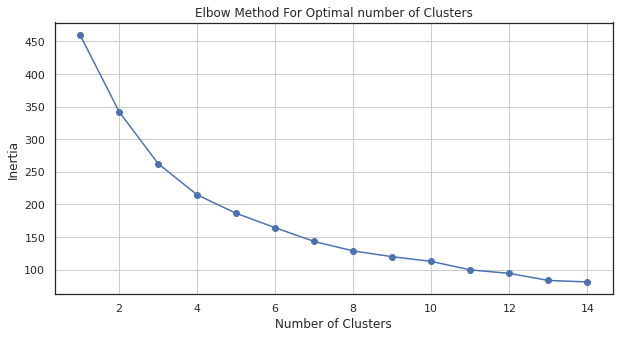

In [118]:
optimise_k_means(volume_t[['climb_t', 'us_lpd_t', 'speed_t', 'volume_t']], 15)

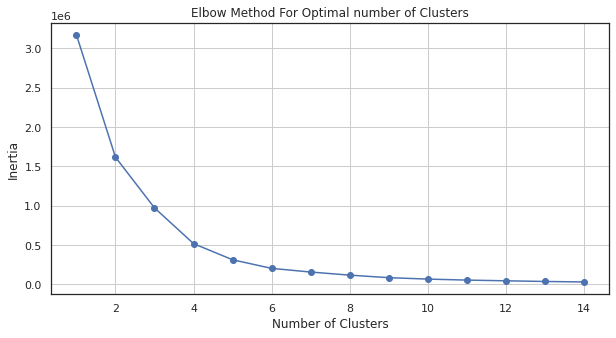

In [119]:
optimise_k_means(volume[['climb', ' us_lpd', 'speed', 'volume']], 15)

In [120]:
from sklearn.metrics import silhouette_samples, silhouette_score

range_n_clusters = [2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 17]
silscore = []
X2 = volume_t[[ 'us_lpd_t', 'volume_t']].copy()

for n_clusters in range_n_clusters:
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X2)
    silhouette_avg = silhouette_score(X2, cluster_labels)
    silscore.append(silhouette_avg)
    print("For n_clusters =", n_clusters,"The average silhouette_score is :", silhouette_avg)
    sample_silhouette_values = silhouette_samples(X2, cluster_labels)

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change fro

For n_clusters = 2 The average silhouette_score is : 0.6155615039769924
For n_clusters = 3 The average silhouette_score is : 0.5693937339101394
For n_clusters = 4 The average silhouette_score is : 0.6104053704666942
For n_clusters = 5 The average silhouette_score is : 0.6096743733132539
For n_clusters = 6 The average silhouette_score is : 0.5749805264692972
For n_clusters = 7 The average silhouette_score is : 0.5590378949805368
For n_clusters = 8 The average silhouette_score is : 0.5578535557605693


/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



For n_clusters = 9 The average silhouette_score is : 0.5493884707907682
For n_clusters = 10 The average silhouette_score is : 0.5495740757487663
For n_clusters = 15 The average silhouette_score is : 0.5140893699273119


/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



For n_clusters = 17 The average silhouette_score is : 0.49770680766220304


Correlation between features

<Axes: >

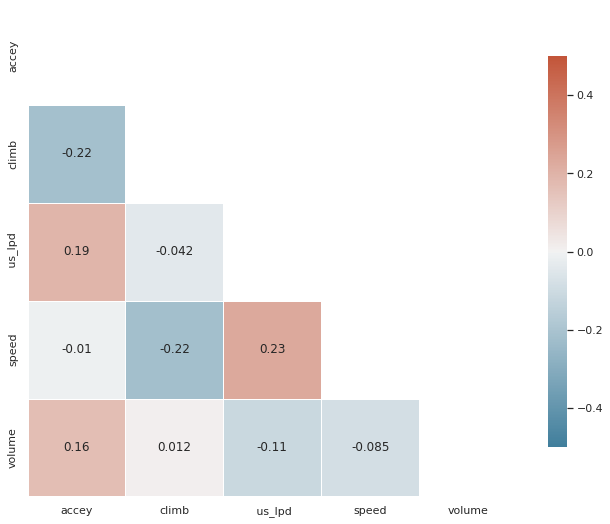

In [121]:
sns.set_theme(style="white")

# Compute the correlation matrix
corr = volume[['accey','climb', ' us_lpd', 'speed', 'volume']].corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, annot = True, vmax=.5, vmin=-.5, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .8})

In [122]:
for k in range(2,7):
  kmeans=KMeans(n_clusters=k)
  kmeans.fit(volume_t[['climb_t', 'us_lpd_t', 'speed_t', 'volume_t']])
  volume_t[f'KMeans_{k}'] = kmeans.labels_

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change fro

Clustering Visualization

In [123]:
import plotly.express as px
fignew = px.scatter(y=volume_t['latitude'], x=volume_t['longitude'], size=volume_t[' us_lpd'], color=volume_t['KMeans_3'], size_max=25)
fignew.show()

###html converter

In [124]:
#!pip install nbconvert
#%%shell
!jupyter nbconvert --to html /content/drive/MyDrive/MSc/MSc_Analysis.ipynb 
print('Notebook salved in .html file')

[NbConvertApp] Converting notebook /content/drive/MyDrive/MSc/MSc_Analysis.ipynb to html
[NbConvertApp] Writing 2886176 bytes to /content/drive/MyDrive/MSc/MSc_Analysis.html
Notebook salved in .html file
